# Intro / Goals / Context


## Goal: 

Predict the fare of taxi tours

Is this a meaningful goal, or some placeholder task to do something?

## Question to Public:

" What kind of feature do you think necessary to have?"

" Why is this a datascience question?"

  - Uncertainty about the driver


# Motivation for the workshop?


What makes spatial data special? 
What kind of novel problems we face by working with spatial data?

    
    * COMPUTING DISTANCES: understand the spatial data properties (e.g. lat/lon, geodesical view)
    
    * being able to VISUALISE these datasets
        * plot heat maps on geographical backgrounds
        
    * ROUNDING must respect the architecture of the city, roads and building (example: route tracing should turn around the buildings).
    
    
    
# Modelling

## Get data and make exploratory plots to clean it.

* Use Kepler on cleaned data and develop a nice intuition.

## Baseline Model 00 (SO + CM)

* Explain Euclidean distance
* predict fare using the Euclidean distance
    Fare ~ 1 + EuclideanDistance
* Discuss what is the problem with the Euclidean distance.
    * TEACHING: Different types of distances
    * Have function definitions for different types of distances, explain code.
* Run the same model with different types of distances, and evaluate how much better the model becomes...
    Fare ~ 1 + X_Distance
    
## Updated Model 01 (EJ)

* use H3 hexagones as categorical features with the idea of capturing systematic variations in locations e.g. center of the city being more busy in general in comparison to a tour along the periphery of the city.


* demand within an hexagon.


## Updated Model 02 

* Daily seasonality: hour of the day as a feature with the idea 
    
    
## Updated Model 03 (CM)

Use https://osmcode.org/pyosmium/ to get route features.

* Get features from the route between pickup and dropoff
  ** # of traffic lights
  ** Allowed speed limit
  ** Number of lanes
  ** Number of hard lefts


## DISCUSSION

how to incorporate traffic information?


# (QUESTIONS for us) /

* do we want to train the model on all train data: Memory considerations


* Why is this task meaningful? 
    ** A simple rule is generating these data, why do we need data science to recover a known rule?
    
    ** how is what we want to do different than applying the rule that generates taxi fares?
    
    
* Are we going to train the model on the fly? If so, how long does it to fit it to 50 millions data points.


    

In [1]:
# %pip install pyproj

In [2]:
# libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import keplergl
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from geopandas import GeoSeries

from utils.osrm_router.OSRMFramework import OSRMFramework
from utils.visualisation.lines import plot_linestring
from utils.geometry.conversor import latlon2linestring

###### constants
TARGET = 'fare_amount'
OSRM_PATH = 'localhost:5000'


In [3]:
# df = pd.read_csv('https://raw.githubusercontent.com/caiomiyashiro/geospatial_data_analysis/master/data/sample_100000.csv')
df = pd.read_csv('data/sample_100000.csv')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
display(df.head())
display(df.dtypes)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,8.1,2009-01-23 07:28:00,-73.996070,40.732605,-73.980675,40.761864,1
1,9.0,2014-01-04 21:11:00,-73.977640,40.752346,-73.970390,40.768867,2
2,6.5,2015-06-22 01:54:24,-74.000080,40.728610,-73.988730,40.722170,6
3,4.5,2010-11-24 12:46:52,-73.962685,40.775646,-73.957436,40.777767,1
4,4.5,2011-11-01 02:19:34,-73.996300,40.753600,-73.998800,40.761100,1


fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

# Split training and testing before analysis

In [4]:
def split_training_test(df, target=TARGET, test_size=0.2):
    X = df.drop(TARGET, axis=1)
    y = df[TARGET]
    return train_test_split(X, y, test_size=test_size, random_state=0) 

def join_Xy(df, target, target_str=TARGET):
    df_ = df.copy()
    df_[target_str] = target
    return df_

def get_initial_training_testing_set(df):
    X_train, X_test, y_train, y_test = split_training_test(df)
    print(f'Shape X_train {X_train.shape}')
    print(f'Shape X_test {X_test.shape}')

    # join target for easier exploratory analysis
    df_train = join_Xy(X_train, y_train)
    df_test = join_Xy(X_test, y_test)
    return df_train, df_test

df_train, df_test = get_initial_training_testing_set(df)

Shape X_train (80000, 6)
Shape X_test (20000, 6)


# Exploratory Analysis

* latitudes/longitudes 0
* check points on the map - maybe find new york shapefile and remove points outside polygon
* Questions to look at kepler?
* Some trips, like to/from an airport, are fixed fee.

# Model 00 - Euclidean Distance

## Start experiment tracking

In [5]:
iteration_results = {}

In [6]:
def euclidean_distance(x1, y1, x2, y2):
    return (((x2-x1)**2 + (y2-y1)**2)**(1/2))

df_train_temp = df_train.head(3).copy()
# Show how unrealistic it is, IF it's unrealisic
df_train_temp['euclidean_dist'] = euclidean_distance(df_train_temp['pickup_latitude'], df_train_temp['dropoff_latitude'], 
                                                   df_train_temp['pickup_longitude'], df_train_temp['dropoff_longitude'])

df_train_temp


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,euclidean_dist
10382,2009-02-03 08:52:00,-73.97087,40.788616,-73.965706,40.774487,1,6.9,162.280780
73171,2010-04-22 20:14:00,-73.97037,40.761692,-73.803375,40.762497,5,29.7,162.138167
30938,2012-01-14 12:45:11,-73.97719,40.784420,-73.996500,40.748596,1,13.3,162.285749


In [7]:
def standardize_features(df):
    df_copy = df.copy()
    col_names = df_copy.columns
    ixs = df_copy.index
    return pd.DataFrame(StandardScaler().fit_transform(df_copy), columns=col_names, index=ixs)

def pre_processing_pipeline_1(df, target_col=TARGET,
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude'):
  
    EUCLIDEAN_FEAT = 'euclidean_dist'
    FEATURES = [EUCLIDEAN_FEAT]

    df_copy = df.copy()
    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                                 df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res

df_train_1= pre_processing_pipeline_1(df_train)
df_test_1 = pre_processing_pipeline_1(df_test)



In [8]:
model_1 = LinearRegression()
model_1.fit(df_train_1.drop(TARGET, axis=1), df_train_1[TARGET])

y_test_pred_1 = model_1.predict(df_test_1.drop(TARGET, axis=1))

Mean Absolute Error: 5.9948500667004065


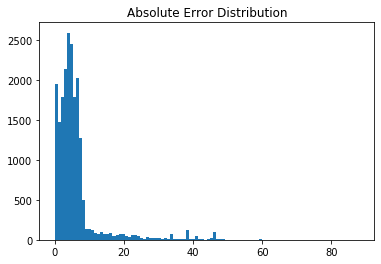

In [9]:
def print_evaluation(y_obs, y_pred, max_lim_y=100, return_errors=True):
    mae_hist = np.abs(y_pred - y_obs)
    plt.hist(mae_hist[y_obs < max_lim_y], bins=100)
    plt.title('Absolute Error Distribution');

    if(return_errors == True):
        return mae_hist

#####
mae = mean_absolute_error(df_test_1[TARGET], y_test_pred_1)
iteration_results['exp_1_mae'] = mae
print(f'Mean Absolute Error: {mae}')

print_evaluation(df_test_1[TARGET], y_test_pred_1, return_errors=False)

## Experimenting on different types of distance
### Haversine - Explain
### Great Circle - Explain


In [10]:
def lat_longs2radians(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    return lon1, lat1, lon2, lat2

def haversine_distance(lat1, lat2, lon1, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = lat_longs2radians(lon1, lat1, lon2, lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# TODO: manhattan with lat lon has NOT worked - see attempt below
# def manhattan_distance(lon1, lat1, lon2, lat2):
#   lon1, lat1, lon2, lat2 = lat_longs2radians(lon1, lat1, lon2, lat2)
#   dlon = np.abs(lon2 - lon1)
#   dlat = np.abs(lat2 - lat1)
#   return dlon + dlat

df_train_temp = df_train.head(3).copy()
df_train_temp['haversine_dist'] = haversine_distance(df_train_temp['pickup_latitude'], df_train_temp['dropoff_latitude'], 
                                                   df_train_temp['pickup_longitude'], df_train_temp['dropoff_longitude'])


# df_train_temp['manhattan_dist'] = manhattan_distance(df_train_temp['pickup_latitude'], df_train_temp['dropoff_latitude'], 
#                                                    df_train_temp['pickup_longitude'], df_train_temp['dropoff_longitude'])

df_train_temp


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine_dist
10382,2009-02-03 08:52:00,-73.97087,40.788616,-73.965706,40.774487,1,6.9,1.629105
73171,2010-04-22 20:14:00,-73.97037,40.761692,-73.803375,40.762497,5,29.7,14.056115
30938,2012-01-14 12:45:11,-73.97719,40.784420,-73.996500,40.748596,1,13.3,4.299907


In [11]:
# trying to convert to UTM and use traditional euclidean space to calculate manhattan BUT IT DIDN'T WORK



# from pyproj import Proj, transform

# inProj = Proj(init='epsg:4326')  # lat lon
# outProj = Proj(init='epsg:3857') # UTM

# lat_pickup_utm, lon_pickup_utm = transform(inProj,outProj,df_train['pickup_latitude'].values, df_train['pickup_longitude'].values)
# lat_dropoff_utm, lon_dropoff_utm = transform(inProj,outProj,df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

# df_train['manhattan_dist'] = np_manhattan(np.array(lat_pickup_utm), np.array(lat_dropoff_utm), 
#                                           np.array(lon_pickup_utm), np.array(lon_dropoff_utm))

In [12]:
def pre_processing_pipeline_2(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude'):
    EUCLIDEAN_FEAT = 'euclidean_dist'
    HAVERSINE_FEAT = 'haversine_dist'
    # MANHATTAN_FEAT = 'manhattan_dist'
    FEATURES = [EUCLIDEAN_FEAT, HAVERSINE_FEAT] #, MANHATTAN_FEAT - #not returning MANHATTAN_FEAT because it's wrong

    df_copy = df.copy()

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    df_copy[HAVERSINE_FEAT] = haversine_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # df_copy[MANHATTAN_FEAT] = manhattan_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
    #                                         df_copy[pickup_longitude], df_copy[dropoff_longitude])

    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res

df_train_2 = pre_processing_pipeline_2(df_train)
df_test_2 = pre_processing_pipeline_2(df_test)


In [13]:
model_2 = LinearRegression()
model_2.fit(df_train_2.drop(TARGET, axis=1), df_train_2[TARGET])

y_test_pred_2 = model_2.predict(df_test_2.drop(TARGET, axis=1))

Mean Absolute Error: 5.995354003797517


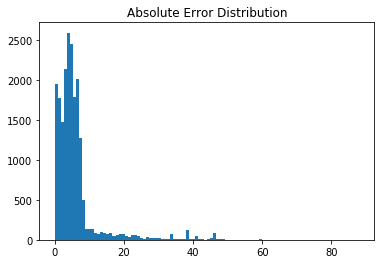

In [14]:
mae_2 = mean_absolute_error(df_test_2[TARGET], y_test_pred_2)
iteration_results['exp_2_mae'] = mae_2
print(f'Mean Absolute Error: {mae_2}')

print_evaluation(df_test_2[TARGET], y_test_pred_2, return_errors=False)

In [15]:
iteration_results

{'exp_1_mae': 5.9948500667004065, 'exp_2_mae': 5.995354003797517}

# Creating a router - OSRM Router

## Calculate street distances and durations

## Setup

Setting local docker image for ORSM back-end - https://hub.docker.com/r/osrm/osrm-backend/

* wget http://download.geofabrik.de/north-america/us/new-york-latest.osm.pbf (file is ~200 Mb)

* Move file to your project folder

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-partition /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-customize /data/new-york-latest.osm.pbf

* docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/new-york-latest.osm.pbf

Example latitude longitude New York: `-73.996070,40.732605;-73.980675,40.761864`

Test: `curl "http://localhost:5000/route/v1/driving/-73.996070,40.732605;-73.980675,40.761864?steps=false&geometries=geojson&annotations=true"`

In [17]:
lat1, lon1 = 40.732605,-73.996070
lat2, lon2 = 40.761864,-73.980675

osm = OSRMFramework('localhost:5000')
lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)

t = latlon2linestring(lat, lon)

plot_linestring(t)

In [ ]:
import requests
import numpy as np
import pandas as pd


class OSRMFramework():
    def __init__(self, OSRM_server_path):
        self.server_url = OSRM_server_path

    def route(self, lat1, lon1, lat2, lon2, max_n_routes=1):
        """
        :example:
        lat1, lon1 = 52.506327, 13.401115
        lat2, lon2 = 52.496891, 13.385983

        # after setting local osrm - https://hub.docker.com/r/osrm/osrm-backend/
        osm = OSRMFramework('localhost:5000')
        lat, lon, distance, duration = osm.route(lat1, lon1, lat2, lon2)
        """
        SERVICE = 'route'
        optionals = {'geometries': 'geojson', 'annotations':'true'}

        long_lat1 = [lon1, lat1]
        long_lat2 = [lon2, lat2]
        coords = [long_lat1, long_lat2]
        coords = ';'.join([f'{lon},{lat}' for lon, lat in coords])

        optionals_str = '?'
        for k, v in optionals.items():
            optionals_str += f'{k}={v}&'
        optionals = optionals_str[:-1]

        query = f'http://{self.server_url}/{SERVICE}/v1/driving/{coords}{optionals}'
        # print(f'query: {query}')
        response = requests.get(query).json()

        if(response['code'] == 'Ok'):
            main_route = response['routes'][0]
            coordinates = [long_lat1] + main_route['geometry']['coordinates']
            distance = main_route['distance']
            duration = main_route['duration']

            lat = [elem[1] for elem in coordinates]
            lon = [elem[0] for elem in coordinates]

            osm_node_ids = main_route['legs'][0]['annotation']['nodes']

            return lat, lon, distance, duration, osm_node_ids
        else:
            return np.nan, np.nan, np.nan, np.nan, np.nan

    def match(self, lat, lon, timestamps=None, radiuses=None):
        """
        :example:
        lat = [52.51156939,52.51148186,52.51102356,52.51077686,52.51063361,52.51046813,52.51030345,52.51013817,52.50997492,52.50980902,
               52.50978678,52.50981555,52.50984412,52.50986943,52.50989677,52.50989554,52.50985494,52.50976862,52.50968128,52.50960578]
        lon = [13.37081563, 13.37085016, 13.37053299, 13.36909533, 13.36821422, 13.36722583, 13.36624146, 13.36526077, 13.3642878, 13.36323738,
               13.36231135, 13.36137023, 13.36044654, 13.35955068, 13.35856128, 13.35757691, 13.35658886, 13.355578  , 13.3546114 , 13.35361328]
        timestamps = ['2019-05-31 06:04:46', '2019-05-31 06:04:56','2019-05-31 06:05:06', '2019-05-31 06:05:16','2019-05-31 06:05:21',
                      '2019-05-31 06:05:26','2019-05-31 06:05:31', '2019-05-31 06:05:36','2019-05-31 06:05:41', '2019-05-31 06:05:46',
                      '2019-05-31 06:05:51', '2019-05-31 06:05:56','2019-05-31 06:06:01', '2019-05-31 06:06:06','2019-05-31 06:06:11',
                      '2019-05-31 06:06:16','2019-05-31 06:06:21', '2019-05-31 06:06:26','2019-05-31 06:06:31', '2019-05-31 06:06:36']
        radiuses = [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]

        osm = OSRMFramework('localhost:5000')
        lat, lon = osm.match(lat, lon, timestamps, radiuses)
        """
        SERVICE = 'match'
        optionals = {'geometries': 'geojson'}

        if (timestamps is not None):
            timestamp_unix = pd.to_datetime(timestamps, format='%Y-%M-%d %H:%m:%S').strftime('%s')
            timestamp_unix = ';'.join(timestamp_unix)
            optionals['timestamps'] = timestamp_unix

        if (radiuses is not None):
            # increase chance of finding correct candidate by doubling std (95% chance)
            RADIUS_TOLERANCE_MULT = 1
            radiuses = np.array(radiuses * RADIUS_TOLERANCE_MULT).astype(str)
            radiuses = ';'.join(radiuses)
            optionals['radiuses'] = radiuses

        optionals_str = '?'
        for k, v in optionals.items():
            optionals_str += f'{k}={v}&'
        optionals = optionals_str[:-1]  # remove last "&"

        coords = [[lon_, lat_] for lon_, lat_ in zip(lon, lat)]
        coords_str = ';'.join([f'{lon},{lat}' for lon, lat in coords])

        query = f'http://{self.server_url}/{SERVICE}/v1/driving/{coords_str}{optionals}'

        response = requests.get(query).json()
        if (response['code'] == 'Ok'):
            match_coords = response['matchings'][0]['geometry']['coordinates']

            lon = [elem[0] for elem in match_coords]
            lat = [elem[1] for elem in match_coords]

            return lat, lon
        else:
            raise Exception(f"Error in Mapmatching: {response['code']}")

In [20]:
def get_route(osm, lat1, lon1, lat2, lon2):
    lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)
    return_col_names = ['route', 'distance_m', 'duration_sec']
    if(type(lat) == float):
        return pd.Series([np.nan,np.nan,np.nan], index=return_col_names)
    else:
        return pd.Series([latlon2linestring(lat, lon), distance, duration], index=return_col_names)

routes = df_train.head().apply(lambda row: get_route(osm, 
                                            row['pickup_latitude'],
                                            row['pickup_longitude'],
                                            row['dropoff_latitude'],
                                            row['dropoff_longitude']), axis=1)
routes['route'] = GeoSeries([elem[0] for elem in routes['route']], index=routes.index)
routes

,route,distance_m,duration_sec
10382,"LINESTRING (-73.97086999999999 40.788616, -73....",2859.9,320.2
73171,"LINESTRING (-73.97036999999999 40.761692, -73....",16026.9,1105.2
30938,"LINESTRING (-73.97719000000001 40.78442, -73.9...",5332.8,497.6
99310,"LINESTRING (-73.97955 40.761967, -73.979544 40...",1298.6,160.9
58959,"LINESTRING (-73.98612 40.75755, -73.9862119999...",896.4,115.0


In [21]:
%%time

def pre_processing_pipeline_3(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude',
                              osm_router=OSRM_PATH):
    EUCLIDEAN_FEAT = 'euclidean_dist'
    HAVERSINE_FEAT = 'haversine_dist'
    # MANHATTAN_FEAT = 'manhattan_dist'
    ROUTE_DISTANCE = 'route_distance_meters'
    ROUTE_DURATION = 'route_duration_seconds'
    
    FEATURES = [EUCLIDEAN_FEAT, 
                HAVERSINE_FEAT, #, MANHATTAN_FEAT - #not returning MANHATTAN_FEAT because it's wrong
                ROUTE_DISTANCE,
                ROUTE_DURATION] 

    df_copy = df.copy()

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    df_copy[HAVERSINE_FEAT] = haversine_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # df_copy[MANHATTAN_FEAT] = manhattan_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
    #                                         df_copy[pickup_longitude], df_copy[dropoff_longitude])
    routes = df_copy.apply(lambda row: get_route(osm, 
                                            row['pickup_latitude'],
                                            row['pickup_longitude'],
                                            row['dropoff_latitude'],
                                            row['dropoff_longitude']), axis=1)
    df_copy[ROUTE_DISTANCE] = routes['distance_m']
    df_copy[ROUTE_DURATION] = routes['duration_sec']
    
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res, routes

df_train_3, routes_train = pre_processing_pipeline_3(df_train)
df_test_3, routes_test = pre_processing_pipeline_3(df_test)


CPU times: user 6min 5s, sys: 41.3 s, total: 6min 46s
Wall time: 15min 50s


In [22]:
model_3 = LinearRegression()
model_3.fit(df_train_3.drop(TARGET, axis=1), df_train_3[TARGET])
y_test_pred_3 = model_3.predict(df_test_3.drop(TARGET, axis=1))


Mean Absolute Error: 3.225331616523993


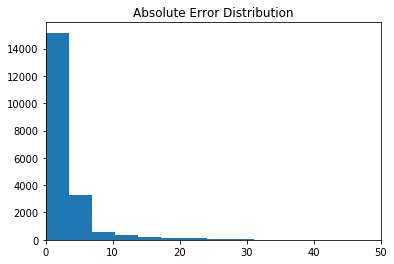

In [23]:
#####
mae_3 = mean_absolute_error(df_test_3[TARGET], y_test_pred_3)
iteration_results['exp_3_mae'] = mae_3
print(f'Mean Absolute Error: {mae_3}')

print_evaluation(df_test_3[TARGET], y_test_pred_3, return_errors=False)
plt.xlim([0, 50]);

# 2nd Exploratory Analysis

In [24]:
df_train_3['y_pred'] = model_3.predict(df_train_3.drop(TARGET, axis=1))
df_train_3['abs_err'] = np.abs(df_train_3[TARGET] - df_train_3['y_pred'])

df_train_3['abs_err'].describe(percentiles=[.9, .95]) # focus on worst 5% first

count    79990.000000
mean         3.242372
std          5.972474
min          0.000031
50%          1.995664
90%          5.828911
95%         10.098026
max        425.871183
Name: abs_err, dtype: float64

In [25]:
df_train_kepler = df_train_3.loc[df_train_3['abs_err'] > 5].copy()

In [26]:
df_train_kepler = df_train_kepler.merge(df_train, 
                      how='left',
                      left_index=True,
                      right_index=True)

df_train_kepler.head(3)

,euclidean_dist,haversine_dist,route_distance_meters,route_duration_seconds,fare_amount_x,y_pred,abs_err,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_y
73171,0.135347,-0.013348,1.052759,1.316575,29.7,24.645644,5.054356,2010-04-22 20:14:00,-73.97037,40.761692,-73.803375,40.762497,5,29.7
83847,0.141886,-0.030675,0.658672,0.538759,21.5,16.405214,5.094786,2013-06-01 18:51:49,-73.95472,40.811610,-73.988110,40.745850,1,21.5
14977,0.145505,-0.000907,3.074711,4.418055,76.5,57.010018,19.489982,2013-12-26 08:04:03,-73.98011,40.763996,-74.177600,40.690520,1,76.5


In [27]:
w1 = keplergl.KeplerGl(height=500)
w1.add_data(data=df_train_kepler, name='bad_instances')
w1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'bad_instances': {'index': [73171, 83847, 14977, 29512, 52436, 83083, 99291, 95185, 55522, 2586…

# Playground

## Proxy to traffic

In [36]:
from utils.osm_annotator.RouteAnnotator import RouteAnnotator

In [197]:
import osmnx as ox
import numpy as np
import networkx as nx

from itertools import combinations

class RouteAnnotator():

    # TODO add different forms of network retrieval from OSMNx
    def __init__(self, place, network_type):

        self.segment_lookup_ = None
        self.way_lookup_ = None
        self.node_lookup_ = None
        self.G = None

        # TODO: Need adjustent. See https://wiki.openstreetmap.org/wiki/New_York
        self.HIGHWAY_SPEED_LIMITS ={   # copied from https://github.com/Project-OSRM/osrm-backend/blob/master/profiles/car.lua
            'motorway':90,
            'motorway_link':45,
            'trunk':85,
            'trunk_link':40,
            'primary':65,
            'primary_link':30,
            'secondary':40, # original: 55 - changed to NY where secondary = 25 mph ~= 40 kmh
            'secondary_link':25,
            'tertiary':40,
            'tertiary_link':20,
            'unclassified':25,
            'residential':40,
            'living_street':10,
            'service':15,
            'footway': 4,    # custom
            'path': 4,       #
            'pedestrian': 4, #
            'steps': 2,      #
            'track': 4,      #
            'piste': 4,      #
            'corridor': 4,   #
            'bridleway': 4,  #
            'razed': 4,      #
            'elevator': 0.2  #
        }

        self.G = ox.graph_from_place(place, network_type=network_type, simplify=False) # example - 'new york, usa'
        self.add_speeds()
        self._build_lookups()

    def add_speeds(self):

        for u, v, k, data in self.G.edges(data=True, keys=True):
            if 'maxspeed' in data and type(data['maxspeed']) == str and data['maxspeed'].isdigit():
                continue
            else:
                if(type(data['highway']) == list): # sometimes data['highway'] comes with a list
                    cond = [elem in self.HIGHWAY_SPEED_LIMITS for elem in data['highway']]
                    highway_type = data['highway'][np.where(cond)[0][0]]
                else:
                    highway_type = data['highway']

                if(highway_type in self.HIGHWAY_SPEED_LIMITS):
                    speed = self.HIGHWAY_SPEED_LIMITS[highway_type]
                    data['maxspeed'] = speed

    def _build_lookups(self):
        # build segment lookup
        segment_lookup = {}
        segment_lengths = {}
        way2nodes = {}
        way2nodes_pair = {}
        way_lookup = {}
        way_segment_lengths = {}
        node_lookup = {}

        # build segment lookup
        for u, v, k, data in ra.G.edges(data=True, keys=True):

            if(type(data['osmid']) != list):
                way_ids = [data['osmid']]
            else:
                way_ids = data['osmid']

            for way in way_ids:
                if(way not in way2nodes.keys()):
                    way2nodes[way] = []
                    way2nodes_pair[way] = []
                    way_lookup[way] = data
                    way_segment_lengths[way] = []
                way2nodes[way].extend([u,v])                    # add all nodes associated to a way
                way2nodes_pair[way].append([u,v])               # add pair of nodes belonging to way id
                way_segment_lengths[way].append(data['length']) # collect way lengths to sum up afterwards

            if(u not in segment_lengths.keys()):                # store each node-node direct segment length. 
                segment_lengths[u] = {}                         # NOT DOING ANYTHING WITH IT FOR NOW
            segment_lengths[u][v] = data['length']

        # 1st FOR, build node id sequence belonging to way_id
        # 2nd FOR, sum segments lengths and add node id list to way lookup
        final_node_sequence = {}
        for way_id, values in way2nodes_pair.items(): # key: way_id, values: pairs of node ids
            relations = {}
            for pair in values:                       # build dict - key: node_pre - value: node post
                relations[pair[0]] = pair[1]
            keys = relations.keys()
            values_ = relations.values()              # if a key (node_pre) doesn't exist in values
            begin_key = list(keys - values_)          # it means it has only origin = way initial node

            if(len(values) > 1 and len(begin_key) == 1): # if NOT cyclic sequence?
                begin_key = begin_key[0]
                node_sequence = [begin_key]
                val = relations[begin_key]
                try:
                    while(val not in node_sequence):  # run through `relations` finding the node sequence pair by pair
                        node_sequence.append(val)
                        begin_key = val
                        val = relations[begin_key]
                except Exception as e:                # until a pair is not found in the dict anymore = exception
                    e                                 # do nothing in exception
                final_node_sequence[way_id] = node_sequence # and store node "ordered" list as a Way metadata
            else:            
                final_node_sequence[way_id] = list(keys)[0] + list(values_)[0] # if way has only 1 node, store it as it is

        for key, value in way_lookup.items():
            way_lookup[key]['length'] = np.sum(way_segment_lengths[key])
            way_lookup[key]['node_sequence'] = final_node_sequence[key]

        # build dict: key1: node1, key2: node2, value: way_id between ALL pair of nodes id IN way
        nodes2way = {}
        for key, values in way2nodes.items():
            for pair in combinations(values,2): 
                if(pair[0] not in nodes2way.keys()):
                    nodes2way[pair[0]] = {}
                nodes2way[pair[0]][pair[1]] = key
                
        # build dict key1: node_id, value: node_metadata
        for node in ra.G.nodes(data=True):
            node_lookup[node[0]] = node[1]


    def segment_lookup(self, node_id_list):
        if(type(node_id_list) == int):
            return self.segment_lookup_[node_id_list[i]][node_id_list[i+1]]
        else:
            ways_id = []
            i = 0
            while i < len(node_id_list) - 1:
                ways_id.append(self.segment_lookup_[node_id_list[i]][node_id_list[i+1]])
                i += 1
            return ways_id

    def way_lookup(self, way_id_list):
        if(type(way_id_list) == int):
            return self.way_lookup_[way_id_list]
        else:
            ways_lookup = []
            for way in way_id_list:
                ways_lookup.append(self.way_lookup_[way])
            return ways_lookup

    def node_lookup(self, node_id_list):
        if(type(node_id_list) == int):
            return self.node_lookup_[node_id_list]
        else:
            nodes_lookup = []
            for node in node_id_list:
                nodes_lookup.append(self.node_lookup_[node])
            return nodes_lookup


In [198]:
ra = RouteAnnotator('new york, usa', 'drive')

In [200]:
ra.segment_lookup([42421877, 42437949])

TypeError: 'NoneType' object is not subscriptable

In [48]:
ra.node_lookup(42421877)

{'highway': 'traffic_signals',
 'osmid': 42421877,
 'x': -73.9959038,
 'y': 40.7328593}

In [49]:
ra.node_lookup(42437949)

{'highway': 'traffic_signals',
 'osmid': 42437949,
 'x': -73.996351,
 'y': 40.732255}

In [47]:
test_traffic = df_test.merge(routes_test, 
                             how='left',
                             left_index=True,
                             right_index=True)

test_traffic.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,route,distance_m,duration_sec
3582,2014-11-07 17:56:58,0.000000,0.000000,0.000000,0.000000,2,28.5,"0 LINESTRING (0 0, -71.86234 41.065003, -71...",0.0,0.0
60498,2009-10-30 11:51:01,-73.966090,40.792553,-73.980820,40.782620,1,6.9,0 LINESTRING (-73.96609000000001 40.7925530...,2315.4,219.1
53227,2012-04-13 12:31:00,-73.985054,40.763744,-73.982690,40.767097,1,2.9,"0 LINESTRING (-73.98505400000001 40.763744,...",422.9,42.7
21333,2015-05-04 18:10:02,-73.958410,40.768830,-73.990295,40.740290,1,13.5,"0 LINESTRING (-73.95841 40.76883, -73.95841...",6294.1,451.9
3885,2011-12-05 21:45:15,-73.972170,40.759170,-73.980960,40.786797,1,10.1,"0 LINESTRING (-73.97216999999999 40.75917, ...",4073.4,363.6
